In [1]:
import sys
sys.path += [".."]

import smbh
from math import *
import numpy as np
from scipy.special import erf
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Sound speed

$$
    c_s = \sqrt{\dfrac{\gamma R}{\mathcal{M}_w}T_\text{vir}} = \sqrt{\dfrac{\gamma R}{\mathcal{M}_w}\left(\dfrac{\mu m_p G M_h}{2k_BR_\text{vir}}\right)} = \sqrt{\dfrac{\gamma R\mu m_pG}{2\mathcal{M}_wk_B}} \sqrt{\dfrac{M_h}{R_\text{vir}}} \approx 0.614 \sqrt{\dfrac{M_h}{R_\text{vir}}}\text{ kpcGyr$^{-1}$}
$$

In [2]:
from scipy.constants import m_p, k, R
smbh.SOLAR_MASSES * 1e5, m_p

mu = 1.1
gamma = 5 / 3

f = ((gamma * R * mu * m_p * smbh.G) / (2 * k * (mu / 1000)))
f = f ** 0.5
print(f, f * (1e3 / smbh.R_VIR_z20) ** 0.5)

0.6141441129704023 23.38051630990129


In [3]:
def soundSpeedChoksi(mh, z):
    kms = 1.8 * (1 + z) ** 0.5 * (mh / 100) ** (1/3) * (0.304 * (0.678 ** 2) / 0.14) ** (1 / 6)
    return smbh.kmsTokpcGyr(kms)

In [4]:
soundSpeedChoksi(1e3, 20)

18.169224634725687

# Mach function zero

$$
    \ln\Lambda\left[1.5\left(\erf{\dfrac{\mathcal{M}}{\sqrt{2}}} - \sqrt{\dfrac{2}{\pi}}\mathcal{M}e^{-\mathcal{M}^2/2}\right) - 1\right] - 0.5\ln\left(1 - \mathcal{M}^{-2}\right) = 0
$$

In [5]:
def mach(m, lnL = 2.3):
    factor = erf(m / sqrt(2)) - sqrt(2 / np.pi) * m * np.exp(-(m ** 2) / 2)
    f1 = 1.5 * lnL * factor
    f2 = 0.5 * np.log(1 - (m ** -2)) + lnL
    return f1 - f2

fsolve(mach, 1.7)

array([1.73100478])

# Scale length approx
$$
	\mathcal{R}_s = \dfrac{0.01}{\left(1 + \sqrt{2}\right)}\left({\dfrac{M_hG}{100 H(t)^2}}\right)^{1/3}
$$

In [6]:
a = 0.01 / (1 + sqrt(2)) * (smbh.G / 100) ** (1/3)
print("%e" % a)

6.835160e-04


# Density profiles

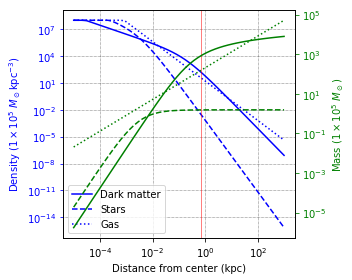

In [2]:
r = np.logspace(-5, 3)

smbh.setBaryonicFraction(0.156)
smbh.setGasPower(-2.2)

smbh.setStellarRatio(0.01)
fig, axs = smbh.plotDensityMassForAll(r, figsize = (5, 4))
fig.savefig("density_mass_fs01.png", dpi = 300)

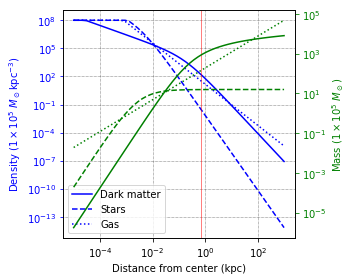

In [3]:
smbh.setStellarRatio(0.1)
fig, axs = smbh.plotDensityMassForAll(r, figsize = (5, 4))
fig.savefig("density_mass_fs1.png", dpi = 300)

# Power law

In [25]:
v0 = 90 * 1.023 # to kpc / gyr

dt = 1e-6
smbh_m = 1

smbh.setStellarRatio(0.01)

In [ ]:
powers = [-1.8, -1.9, -2, -2.1, -2.2, -2.3]

times = []
positions = []
for power in powers:
    smbh.setGasPower(power)
    result = smbh.run([v0, 0, 0], smbh_m, save_every = 10)
    positions.append(result.distance)
    times.append(result.times)
# fig.savefig('properties_s0.02v70.png', dpi = 300)

# plt.show()

Text(0, 0.5, 'Distance (kpc)')

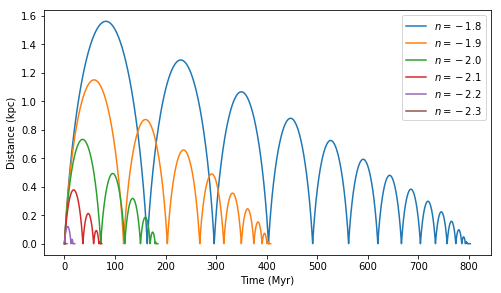

In [24]:
fig, ax = plt.subplots(figsize = (8, 4.5))
for i in range(len(powers)):
    ax.plot(1000 * times[i], positions[i], label = "$n = %.1f$" % powers[i])
ax.legend()
ax.set_xlabel("Time (Myr)")
ax.set_ylabel("Distance (kpc)")

# Simulation results

In [27]:
v0 = 70 * 1.023 # to kpc / gyr

dt = 1e-6
smbh_m = 1

smbh.setStellarRatio(0.01)

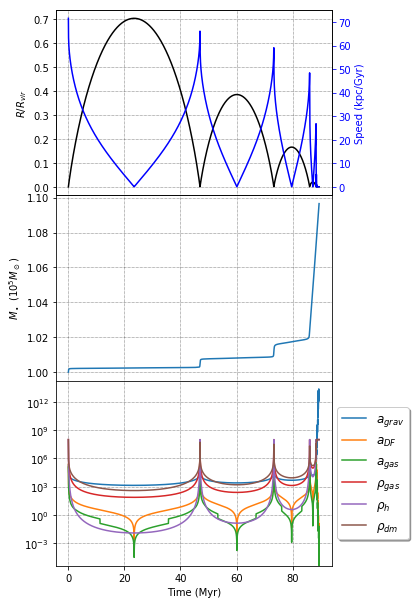

In [29]:
smbh.setGasPower(-2)
result = smbh.run([v0, 0, 0], smbh_m, save_every = 10)

fig, (ax1, ax2, ax3) = smbh.plotProperties(result)

# fig.savefig('properties_s0.02v70.png', dpi = 300)

plt.show()

In [8]:
ratios = np.linspace(0.01, 0.1, 15)
speeds = np.linspace(55, 85, 7).astype(int)
return_times = np.zeros((len(speeds), len(ratios)))

file = "Data/return_%d_%d.dat" 

In [9]:
smbh.setR_vir(smbh.R_VIR_z20)
for (i, speed) in enumerate(speeds):
    speed = smbh.kmsTokpcGyr(speed)
    for (j, ratio) in enumerate(ratios):
        smbh.setStellarRatio(ratio)
        result = smbh.run([0, 0, 0], [speed, 0, 0], 1, save_every = 10)
        return_times[i, j] = result.getReturnTime()
#     print("%d" % speed)

return_times = 1000 * return_times

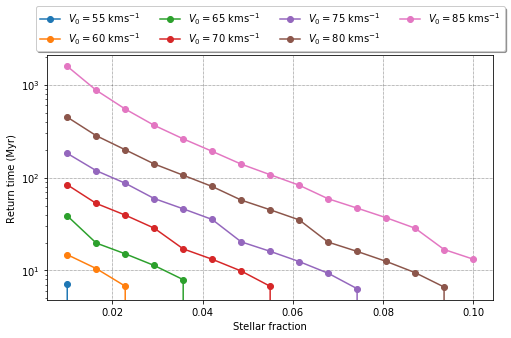

In [10]:
fig, ax = plt.subplots(figsize = (8, 4.5))

# colors = cm.jet(np.linspace(0, 1, len(speeds)))

for (i, times) in enumerate(return_times):
    pos = times <= 0.1
    times[pos] = 0
    ax.plot(ratios, times, "-o", label = "$V_0 = %d$ kms$^{-1}$"%speeds[i])
    
ax.set_xlabel("Stellar fraction")
ax.set_ylabel("Return time (Myr)")

ax.set_yscale("log")
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.22),
          ncol = 4, fancybox = True, shadow = True)
ax.grid()

In [57]:
# np.savetxt("return_times_smbh1_mh1e3.dat", return_times.T)
# np.savetxt("return_times_ratios.dat", ratios)
# np.savetxt("return_times_speeds.dat", speeds)